# Exploring Dandiset 001366: Surface Vessel Diameter and Pulsatility Quantification

**Notice:**  
This notebook was generated with the assistance of AI. Please double-check all code and interpretations before using any results for research or publication.

---

## Overview

[Dandiset 001366](https://dandiarchive.org/dandiset/001366/0.250324.1603) contains movies of mouse pial vessels captured for the purpose of comparing analysis methods (such as full width at half maximum and radon transform) for quantifying vessel diameter and pulsatility. Both files are stored in the NWB (Neurodata Without Borders) format and hold time-series imaging data.

| File | Frames | Image size | Frame rate (Hz) | Subject | Notes |
|------|--------|------------|-----------------|---------|-------|
| sub-F15/sub-F15_ses-F15BC-19102023_image.nwb | 9553 | 214×132 | 54.47 | F15 | University of Copenhagen |
| sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb | 6000 | 512×512 | 30.0 | 031224_M4 | University of Rochester |

This notebook acts as a quick introduction for exploring the data structure, accessing and visualizing sample frames, investigating sample intensity dynamics, and demonstrating basic vessel quantification methods.

---

## What You'll Find in This Notebook

1. **Setup and Requirements**
2. **Accessing Dandiset Assets with the DANDI API**
3. **Loading and Summarizing NWB File Structure**
4. **Visualizing Imaging Data (Sample Frames)**
5. **Computing Intensity Dynamics (Time Series)**
6. **Demonstrating Vessel Diameter Extraction (FWHM)**
7. **A Brief Look at the Second File's Structure and Data**

Each section contains both explanatory text and code you can use as a template for further analysis.

---

## Required Packages (should already be installed)

- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `matplotlib`
- `numpy`


## 1. Accessing Dandiset 001366 Assets with the DANDI API

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "001366"
dandiset_version = "0.250324.1603"

# Connect and retrieve assets
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    nwb_assets = list(dandiset.get_assets_by_glob("*.nwb"))
    for asset in nwb_assets:
        print(f"Asset: {asset.path}, Size: {asset.size/1e9:.2f} GB")

Asset: sub-F15/sub-F15_ses-F15BC-19102023_image.nwb, Size: 0.41 GB
Asset: sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb, Size: 2.38 GB


Below, we will focus first on the file:

```
sub-F15/sub-F15_ses-F15BC-19102023_image.nwb
```

This file contains a single time-series image acquisition ("Movies") with 9553 grayscale frames of 214×132 pixels.

## 2. Loading NWB Data by Streaming the Remote File

We will use `remfile`, `h5py`, and `pynwb` to stream and open the NWB file directly from DANDI, without downloading the entire file.

In [2]:
import pynwb
import h5py
import remfile

# Get the download URL for the NWB asset
target_asset_path = "sub-F15/sub-F15_ses-F15BC-19102023_image.nwb"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset = next(dandiset.get_assets_by_glob(target_asset_path))
    url = asset.download_url

# Stream and open the NWB file
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 3. Basic Structure of the File

Let's inspect the file for its metadata and acquisitions.

In [3]:
# Print general metadata
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Experimenter: {nwb.experimenter}")
print(f"Institution: {nwb.institution}")
print(f"Experiment description: {nwb.experiment_description}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"ImageSeries keys in acquisition: {list(nwb.acquisition.keys())}")

Session description: a wild-type mouse skull was thinned at the area of the middle cerebral artery (MCA) and fitted with a head plate for fixation.
Session start time: 2023-10-19 02:00:00-04:00
Experimenter: ('Ghanizada, Hashmat ',)
Institution: University of Copenhagen
Experiment description: Vessel diameter and pulsatility measurement.
Subject ID: F15
Subject species: Mus musculus
Subject sex: F
ImageSeries keys in acquisition: ['Movies']


## 4. Visualizing a Sample Frame

The "Movies" dataset contains a 3D array: (frames, height, width).

We'll visualize the very first frame.

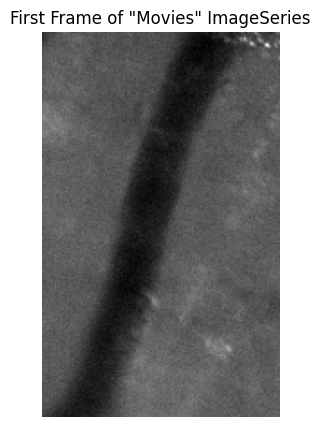

In [4]:
import matplotlib.pyplot as plt
import numpy as np

movies = nwb.acquisition["Movies"]
# The .data attribute can be indexed like an array
frame0 = movies.data[0, :, :]

plt.figure(figsize=(4, 5))
plt.imshow(frame0, cmap="gray")
plt.title('First Frame of "Movies" ImageSeries')
plt.axis("off")
plt.show()

## 5. Time Series: Average Intensity Dynamics

The plot below shows the average pixel intensity across the first 500 movie frames, providing a sense of global brightness variation (e.g., due to blood flow or artifacts).

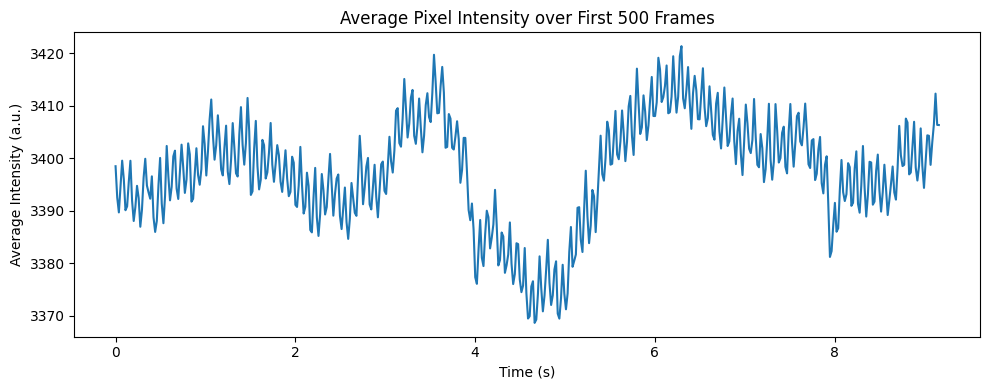

In [5]:
n_frames = 500  # number of frames to sample
frames = movies.data[:n_frames, :, :]
avg_intensity = frames.mean(axis=(1, 2))
frame_rate = movies.rate  # in Hz
times = np.arange(n_frames) / frame_rate

plt.figure(figsize=(10, 4))
plt.plot(times, avg_intensity)
plt.xlabel("Time (s)")
plt.ylabel("Average Intensity (a.u.)")
plt.title("Average Pixel Intensity over First 500 Frames")
plt.tight_layout()
plt.show()

## 6. Extracting Vessel Diameter with Full Width at Half Maximum (FWHM)

Let's estimate the vessel diameter, for a single frame, along the central horizontal line using the FWHM approach.

**Note:** This method assumes the vessel appears dark compared to its surroundings.

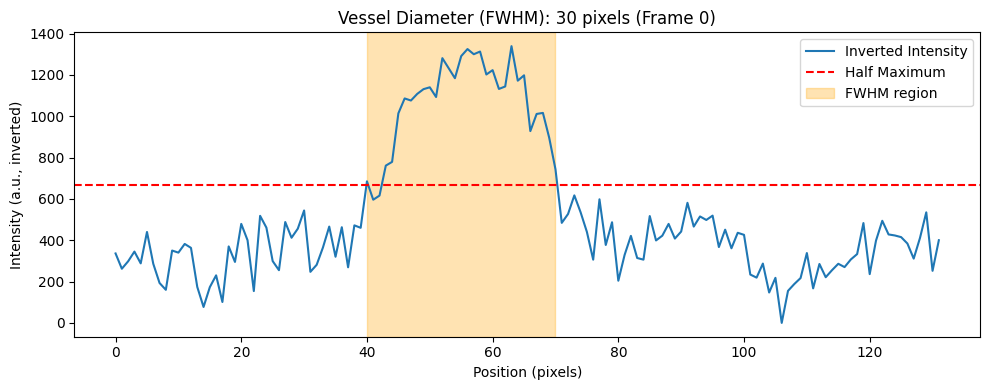

In [6]:
from scipy.signal import find_peaks

frame = movies.data[0, :, :]  # first frame
row = frame.shape[0] // 2
cross_section = frame[row, :]

# Invert for dark vessel (trough) detection
inverted = np.max(cross_section) - cross_section
half_max = (np.max(inverted) + np.min(inverted)) / 2
above_half = inverted > half_max
indices = np.where(above_half)[0]

if len(indices) > 1:
    fwhm_left = indices[0]
    fwhm_right = indices[-1]
    diameter_pixels = fwhm_right - fwhm_left
else:
    fwhm_left = fwhm_right = diameter_pixels = 0  # fallback in rare error case

# Plot
plt.figure(figsize=(10, 4))
plt.plot(inverted, label='Inverted Intensity')
plt.axhline(half_max, color='r', linestyle='--', label='Half Maximum')
plt.axvspan(fwhm_left, fwhm_right, color='orange', alpha=0.3, label='FWHM region')
plt.xlabel('Position (pixels)')
plt.ylabel('Intensity (a.u., inverted)')
plt.title(f'Vessel Diameter (FWHM): {diameter_pixels} pixels (Frame 0)')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Comparing with the Second File

The second NWB file in this dandiset follows the same general structure. It contains a 512×512 field of view at 30 Hz. Below, we'll load and visualize the first frame to confirm.

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


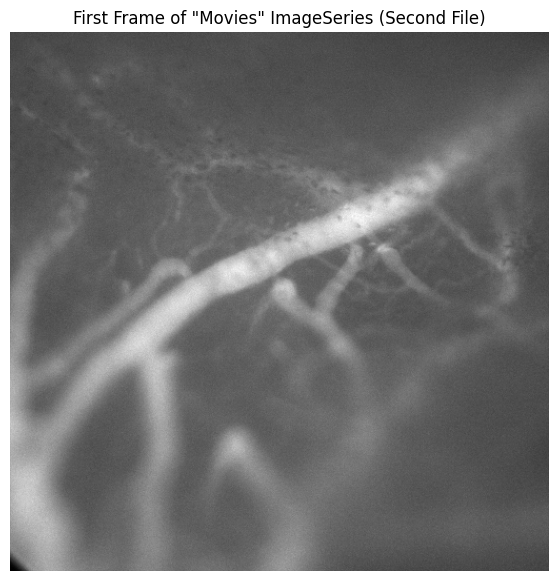

In [7]:
# Get the download URL for the second NWB asset
second_asset_path = "sub-031224-M4/sub-031224-M4_ses-03122024-m4-baseline_image.nwb"
with DandiAPIClient() as client:
    dandiset = client.get_dandiset(dandiset_id, dandiset_version)
    asset2 = next(dandiset.get_assets_by_glob(second_asset_path))
    url2 = asset2.download_url

# Stream and open the second NWB file
remote_file2 = remfile.File(url2)
h5_file2 = h5py.File(remote_file2)
io2 = pynwb.NWBHDF5IO(file=h5_file2, load_namespaces=True)
nwb2 = io2.read()

movies2 = nwb2.acquisition["Movies"]
frame0_2 = movies2.data[0, :, :]

plt.figure(figsize=(7, 7))
plt.imshow(frame0_2, cmap="gray")
plt.title('First Frame of "Movies" ImageSeries (Second File)')
plt.axis("off")
plt.show()

---

## Summary and Next Steps

You have explored the asset listing, metadata, structure, imaging content, and performed simple analyses using both NWB files of Dandiset 001366.  

**Where to go next?**
- Automate diameter or pulsatility extraction over time
- Process time-series for physiological signals
- Apply vessel segmentation or alternative quantification methods

**Remember:** Always review methods and assumptions for your scientific context!